## Домашнее задание №1

В этом домашнем задании вы познакомитесь с pytorch сами и сможете попрактиковаться в его применении. 

#### План:

1. Простейшие операции в pytorch
2. Пишем Adam и применяем его к ручной модели
3. Обучаем свою первую нейросеть

In [1]:
import os
import sys
import math
import torch
import random
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt


### Простейшие операции на pytorch (2 балла)

**Task**: Cоздайте два случайных тензора (двумерных, не квадратных):

In [ ]:
x = torch.randn((2, 3)) # your code here 
y = torch.randn((3, 2))# your code here 

**Task**: Умножьте их друг на друга, результат запишите в третий тензор без использования оператора `=`:

In [ ]:
z = torch.Tensor() # your code here 
torch.matmul(x, y, out=z)
z

tensor([[-1.1191, -0.7038],
        [-0.0278,  0.0399]])

**Task**: Реализуйте ReLU использую только pytorch, примените его к тензору `x` (запрещено использование модулей torch.nn и его подмодулей, а также функции torch.relu)

In [ ]:
def relu_forward(x):
    return torch.max(torch.zeros_like(x), x)

assert torch.all(F.relu(x) == relu_forward(x))

In [ ]:
relu_forward(z)# your code here 

tensor([[0.0000, 0.0000],
        [0.0000, 0.0399]])

**Task**: Сделайте тоже самое c ELU (запрещено использование модулей torch.nn и его подмодулей):

In [ ]:
def elu_forward(x, alpha = 1.0):
    zeros = torch.zeros_like(x)
    return torch.max(zeros, x) + torch.min(zeros, alpha * (torch.exp(x) - 1))

assert torch.all(F.elu(x) == elu_forward(x))

In [ ]:
elu_forward(z)

tensor([[-0.3228, -0.4927],
        [ 0.5585, -0.1085]])

**Task**: LeakyReLU (запрещено использование модулей torch.nn и его подмодулей):

In [ ]:
def lrelu_forward(x, alpha = 0.01):
    zeros = torch.zeros_like(x)
    return torch.max(zeros, x) + torch.min(zeros, alpha * x)

assert torch.all(F.leaky_relu(x, 0.01) == lrelu_forward(x, 0.01))

In [ ]:
lrelu_forward(z)

tensor([[-0.0039, -0.0068],
        [ 0.5585, -0.0011]])

**Task**: Теперь перейдем к немного более современным функциям активаций, например Mish, напомним как она выглядит:

$$x * tanh(ln(1+e^x))$$

(запрещено использование модулей torch.nn и его подмодулей)

In [ ]:
def mish(x):
    return x * torch.tanh(torch.log(1 + torch.exp(x)))

In [ ]:
assert torch.allclose(
    mish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.8651, 0.8651, 0.8651]), 
    atol=1e-4
)

assert torch.allclose(
    mish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.5014, 0.2908, 0.5280, 0.2663], dtype=torch.float64), 
    atol=1e-4
)

**Task**: Теперь реализуем swish, напомним как она выглядит:

$$x * \sigma(x)$$

(запрещено использование модулей torch.nn и его подмодулей)

In [ ]:
def swish(x):
    return x * torch.sigmoid(x)

In [ ]:
assert torch.allclose(
    swish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.7311, 0.7311, 0.7311]), 
    atol=1e-4
)

assert torch.allclose(
    swish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.4171, 0.2409, 0.4396, 0.2206], dtype=torch.float64), 
    atol=1e-4
)

### Пишем Adam и применяем его к линейной регрессии (4 балла)


В данной секции вам нужно сделать две вещи: 

1. Написать свой собственный оптимизатор подобно тому, который мы писали на семинаре
2. Обучить логистическую регрессию побатчево на картинках из датасета 


#### Adam


$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
m &=& \beta_1 m + (1 - \beta_1) g \\
v &=& \beta_2 v + (1 - \beta_2) diag(gg^{T}) \\
\hat{m} &=& \frac{m}{1 - \beta_1^{t}} \\
\hat{v} &=& \frac{v}{1 - \beta_2^{t}} \\
w &=& w - \frac{\eta}{\sqrt{\hat{v} + \epsilon}} \odot \hat{m}
\end{eqnarray}
$$

In [2]:
# абстрактный класс, не обращайте внимания
from torch.optim import Optimizer


class InClassOptimizer(Optimizer):
    def step(self):
        """Perform single optimization step."""
        with torch.no_grad(): # выключим градиенты
            for group in self.param_groups:
                self._group_step(group)

    def _group_step(self, group):
        # group ~ dict[str, ...]
        """
        Private helper function to perform
        single optimization step on model parameters.
        """
        raise NotImplementedError()

**Task**: Напишите свою реализацию Adam:

In [36]:
class Adam(InClassOptimizer):
    def __init__(self, params, lr=0.001, eps=1e-13, beta_1=0.9, beta_2=0.999):
        defaults = dict(lr=lr, eps=eps, beta_1=beta_1, beta_2=beta_2)
        super().__init__(params, defaults)

    def _group_step(self, group):
        # One group contains information about values passed in init
        # and model parameters to update
        lr = group['lr']
        eps = group['eps']
        beta_1 = group['beta_1']
        beta_2 = group['beta_2']
        for param in filter(lambda x: x.grad is not None, group['params']):
            self._init_adam_buffer(param)
            d_param = param.grad
            buffer, buffer_sq, step = self._get_adam_buffer(param)
            buffer.mul_(beta_1).add_(d_param, alpha=1 - beta_1) # Моменты 1ого порядка
            buffer_sq.mul_(beta_2).addcmul_(d_param, d_param, value=1 - beta_2) # Моменты 2ого порядка
            step += 1 # Шаг
            denom = (buffer_sq / (1 - beta_2 ** step)).add_(eps).sqrt()
            param.addcdiv_(buffer, denom, value=-lr / (1 - beta_1 ** step))

    def _get_adam_buffer(self, param):
        """
        Get accumulated gradients for Adam.

        Parameters
        ----------
        param : `torch.Tensor`, required
            Model parameter to get accumulated gradeints for adam.

        Returns
        -------
        Accumulated Adam gradients for parameter.
        """
        param_state = self.state[param]
        return param_state['adam_buffer'], param_state['adam_buffer_sq'], param_state['step']

    def _init_adam_buffer(self, param):
        """
        Initialize accumulated gradeints for adam.

        Parameters
        ----------
        param : `torch.Tensor`, required
            Model parameter to get accumulated gradeints for adam.
        """
        param_state = self.state[param]
        if 'adam_buffer' not in param_state:
            param_state['adam_buffer'] = torch.zeros_like(param)
        if 'adam_buffer_sq' not in param_state:
            param_state['adam_buffer_sq'] = torch.zeros_like(param)
        if 'step' not in param_state:
            param_state['step'] = 0

**Task**: Создайте параметры для обучения линейной регрессии, сделаем Xavier ициализацию, которая выглядит следующим образом: 

$$w \sim U\left[-\frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}, \frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}\right]$$

где: 

* $n_{in}$ -- размер входа (в нейронах) 
* $n_{out}$ -- размер выхода (в нейронах)

Подумайте над выбором $n_{in}$ и $n_{out}$ самостоятельно. 

In [37]:
torch.manual_seed(13102020)
n_in, n_out = (1*28*28, 10)
weights = torch.autograd.Variable(
    np.sqrt(6) * torch.FloatTensor(n_in, n_out).uniform_(-1.0, 1.0) / np.sqrt(n_in + n_out),
     requires_grad=True) # your code here
intercept = torch.autograd.Variable(
    np.sqrt(6) * torch.FloatTensor(1, n_out).uniform_(-1.0, 1.0) / np.sqrt(n_in + n_out),
     requires_grad=True) # your code here # your code here ??? bias?
bias = intercept

In [38]:
optimizer = Adam([weights, intercept])
loss = nn.CrossEntropyLoss()

Загрузим данные и создадим даталоадеры:

In [6]:
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

fashion_mnist_train = torchvision.datasets.FashionMNIST(
    './data',
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)
train_dataloader = DataLoader(
                              fashion_mnist_train, batch_size=128, shuffle=True, num_workers=1
                              ) # your code here

fashion_mnist_eval = torchvision.datasets.FashionMNIST(
    './data',
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

eval_dataloader = DataLoader(
                            fashion_mnist_eval, batch_size=128, num_workers=1
                            ) # your code here

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Напишите функцию для тренировки логистической регрессии, она должна: 
    * Делать предсказания 
    * Считать лосс 
    * Подсчитывать градиенты
    * Делать шаг оптимизации
    * Обнулять посчитанные градиенты
    * Считать метрики 
    * Возвращать полученные метрики
    
После этого предусмотрите возможность визуализировать метрики, чтобы нарисовать картинки, а именно от вас требуется визуализировать: 

    * Зависимость лосса от количества итераций
    * Зависимость доли правильных ответов от количества итераций

In [7]:
def train_logistic_regression(weights, bias, batch, loss, optimizer):
    imgs, labels = batch
    outputs = torch.matmul(imgs.view(-1, 1*28*28), weights) + bias
    batch_loss = loss(outputs, labels)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == labels).sum().item() / len(labels)
    return batch_loss, accuracy

In [8]:
def eval_metrics(weights, bias, eval_dataloader, loss):
    eval_loss = []
    eval_acc = []
    with torch.no_grad():
      for batch in eval_dataloader:
          imgs, labels = batch
          outputs = torch.matmul(imgs.view(-1, 1*28*28), weights) + bias
          batch_loss = loss(outputs, labels).detach().numpy()
          _, predicted = torch.max(outputs, 1)
          accuracy = (predicted == labels).sum().item() / len(labels)
          eval_loss.append(batch_loss)
          eval_acc.append(accuracy)
      return np.sum(eval_loss) / len(eval_dataloader), np.sum(eval_acc) / len(eval_dataloader)

In [39]:
train_scores = {'loss': [],
                'accuracy': [],
                'epoch_num': [],
                'ep_acc': [],
                'ep_loss': [], 
                'eval_acc': [],
                'eval_loss': []}
for epoch in range(1, 100):
    for batch in train_dataloader:
        metrics = train_logistic_regression(weights, bias, batch, loss, optimizer)
        ### Train metrics ###
        train_scores['loss'].append(metrics[0].detach().numpy())
        train_scores['accuracy'].append(metrics[1])
        train_scores['epoch_num'].append(epoch)

    ### Epoch metrics ###
    losses = np.array(train_scores['loss'])
    accuracy = np.array(train_scores['accuracy'])
    epoch_nums = np.array(train_scores['epoch_num'])
    avg_acc = np.sum(accuracy[epoch_nums == epoch]) / len(train_dataloader)
    avg_loss = np.sum(losses[epoch_nums == epoch]) / len(train_dataloader)
    eval_loss, eval_acc = eval_metrics(weights, bias, eval_dataloader, loss)
    train_scores['eval_acc'] += [eval_acc]*len(train_dataloader)
    train_scores['eval_loss'] += [eval_loss]*len(train_dataloader)
    train_scores['ep_acc'] += [avg_acc]*len(train_dataloader)
    train_scores['ep_loss'] += [avg_loss]*len(train_dataloader)
    print('Epoch {0}, train loss = {1:.4f}, train accuracy = {2:.4f} \n \t eval loss = {3:.4f}, eval accuracy = {4:.4f}'
    .format(epoch, avg_loss, avg_acc, eval_loss, eval_acc))

Epoch 1, train loss = 0.6896, train accuracy = 0.7697 
 	 eval loss = 0.5832, eval accuracy = 0.7996
Epoch 2, train loss = 0.5348, train accuracy = 0.8217 
 	 eval loss = 0.5404, eval accuracy = 0.8170
Epoch 3, train loss = 0.5017, train accuracy = 0.8322 
 	 eval loss = 0.5199, eval accuracy = 0.8246
Epoch 4, train loss = 0.4824, train accuracy = 0.8385 
 	 eval loss = 0.5046, eval accuracy = 0.8275
Epoch 5, train loss = 0.4691, train accuracy = 0.8430 
 	 eval loss = 0.4945, eval accuracy = 0.8312
Epoch 6, train loss = 0.4596, train accuracy = 0.8453 
 	 eval loss = 0.4863, eval accuracy = 0.8318
Epoch 7, train loss = 0.4509, train accuracy = 0.8477 
 	 eval loss = 0.4805, eval accuracy = 0.8338
Epoch 8, train loss = 0.4442, train accuracy = 0.8505 
 	 eval loss = 0.4768, eval accuracy = 0.8348
Epoch 9, train loss = 0.4383, train accuracy = 0.8520 
 	 eval loss = 0.4739, eval accuracy = 0.8365
Epoch 10, train loss = 0.4341, train accuracy = 0.8526 
 	 eval loss = 0.4694, eval accurac

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8a7da1bcf8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Epoch 64, train loss = 0.3733, train accuracy = 0.8708 
 	 eval loss = 0.4342, eval accuracy = 0.8488


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8a7da1bcf8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Epoch 65, train loss = 0.3732, train accuracy = 0.8701 
 	 eval loss = 0.4341, eval accuracy = 0.8458
Epoch 66, train loss = 0.3730, train accuracy = 0.8709 
 	 eval loss = 0.4348, eval accuracy = 0.8472
Epoch 67, train loss = 0.3728, train accuracy = 0.8706 
 	 eval loss = 0.4342, eval accuracy = 0.8470
Epoch 68, train loss = 0.3724, train accuracy = 0.8714 
 	 eval loss = 0.4367, eval accuracy = 0.8464
Epoch 69, train loss = 0.3720, train accuracy = 0.8707 
 	 eval loss = 0.4343, eval accuracy = 0.8467
Epoch 70, train loss = 0.3715, train accuracy = 0.8705 
 	 eval loss = 0.4340, eval accuracy = 0.8475
Epoch 71, train loss = 0.3714, train accuracy = 0.8710 
 	 eval loss = 0.4352, eval accuracy = 0.8462
Epoch 72, train loss = 0.3708, train accuracy = 0.8715 
 	 eval loss = 0.4340, eval accuracy = 0.8476
Epoch 73, train loss = 0.3703, train accuracy = 0.8713 
 	 eval loss = 0.4347, eval accuracy = 0.8478
Epoch 74, train loss = 0.3701, train accuracy = 0.8720 
 	 eval loss = 0.4346, eva

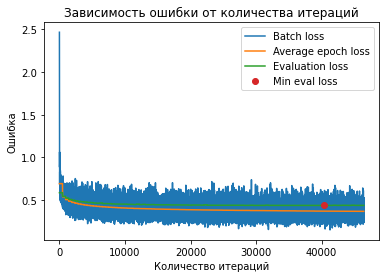

In [40]:
x_arr = np.arange(len(train_scores['loss']))
plt.plot(x_arr, train_scores['loss'], x_arr, train_scores['ep_loss'], x_arr, train_scores['eval_loss'])
plt.title('Зависимость ошибки от количества итераций')
plt.xlabel('Количество итераций')
plt.ylabel('Ошибка')

min_loss = np.argmin(train_scores['eval_loss'])
plt.plot([x_arr[min_loss]], [train_scores['eval_loss'][min_loss]], 'o')

plt.legend(['Batch loss', 'Average epoch loss', 'Evaluation loss', 'Min eval loss'])

plt.show()

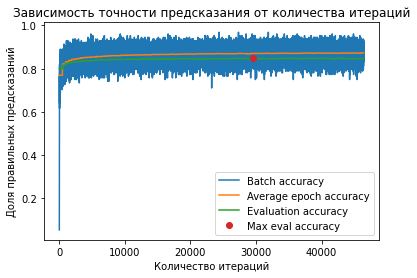

In [41]:
plt.plot(x_arr, train_scores['accuracy'], x_arr, train_scores['ep_acc'], x_arr, train_scores['eval_acc'])
plt.title('Зависимость точности предсказания от количества итераций')
plt.xlabel('Количество итераций')
plt.ylabel('Доля правильных предсказаний')

max_acc = np.argmax(train_scores['eval_acc'])
plt.plot([x_arr[max_acc]], [train_scores['eval_acc'][max_acc]], 'o')

plt.legend(['Batch accuracy', 'Average epoch accuracy', 'Evaluation accuracy', 'Max eval accuracy'])

plt.show()

#### Вопросы к секции: 

* Своими словами и без математики объясните благодаря чему Adam дает несмещенную оценку на квадрат градиента
* Когда модель начала переобучаться? Как вы это поняли? Сделайте визуализацию и докажите свою точку зрения.

1.   Adam дает несмещенную оценку на квадрат градиента, поскольку с помощью экспоненциального сглаживания и коррекции смещения мы усредняем значение квадрата градинта, что позволяет лучше сходится в необходимом направлении
2.   Видно, что за 100 эпох модель не сильно переобучилась. На 27 тыс. итераций модель показала наилучшую точность предсказания. Далее результы практически не улучшаются, обучение можно было бы завершить.


### Моя первая нейросеть (4 балла)

В данной секции вам нужно сделать следующие вещи: 

* Реализовать три разных архитектуры нейросетей. Эти архитектуры должны принципиально отличаться друг от друга. Разрешается одной из архитекур брать полностью полносвязную модель. Остальные две должны быть сверточными и сильно отличаться друг от друга. К примеру, одна из таких архитектур может быть VGG подобная сеть, а другая ResNet подобная архитектура. 

* Написать цикл для обучения которым можно обучать все три модели без изменений кода

* Попробовать каждую модель с двумя оптимизаторами: RMSprop и SGD with momentum

* Визуализировать результаты перфоманса каждой модели (две метрики минимум для каждого сетапа, например, лосс и долю правильных ответов). В данном пункте мы ждем от вас визуализацию зависимости метрики от номера итерации обучения.

* Сделать выводы какие были модели были лучше и как вы думаете почему?

In [ ]:
# train and visualize and write summary down there
from IPython.display import clear_output

device = 'cuda'
torch.cuda.is_available()

True

In [ ]:
# Функция для получения метрик на валидации
def eval_func(model, eval_dataloader, loss):
    eval_loss = []
    eval_acc = []
    model.eval()
    with torch.no_grad():
      for batch in eval_dataloader:
          inputs, labels = batch
          inputs, labels = inputs.to(device), labels.to(device) 
          outputs = model(inputs)
          batch_loss = loss(outputs, labels).detach().to('cpu').numpy()
          _, predicted = torch.max(outputs, 1)
          accuracy = (predicted == labels).sum().item() / len(labels)
          eval_loss.append(batch_loss)
          eval_acc.append(accuracy)
      return np.sum(eval_loss) / len(eval_dataloader), np.sum(eval_acc) / len(eval_dataloader)

In [ ]:
# Функция для визуализации метрик
def plot_metrics(model_history):
  if len(model_history['eval_loss']) == 0:
    return

  fig, ax = plt.subplots(1, 2, figsize=(16,6))
  x_axis = np.arange(len(model_history['loss']))

  # График ошибки
  ax[0].plot(x_axis, model_history['loss'], x_axis, model_history['ep_loss'], x_axis, model_history['eval_loss'])
  ax[0].set_title('Зависимость ошибки от числа итераций')
  ax[0].set_xlabel('Количество итераций')
  ax[0].set_ylabel('Ошибка')

  min_loss = np.argmin(model_history['eval_loss'])
  ax[0].plot([x_axis[min_loss]], [model_history['eval_loss'][min_loss]], 'o')
  ax[0].legend(['Batch loss', 'Average epoch loss', 'Evaluation loss', 'Min eval loss'])

  # График точности предсказания
  ax[1].plot(x_axis, model_history['accuracy'], x_axis, model_history['ep_acc'], x_axis, model_history['eval_acc'])
  ax[1].set_title('Зависимость точности предсказания от числа итераций')
  ax[1].set_xlabel('Количество итераций')
  ax[1].set_ylabel('Точность предсказания')

  max_acc = np.argmax(model_history['eval_acc'])
  ax[1].plot([x_axis[max_acc]], [model_history['eval_acc'][max_acc]], 'o')
  ax[1].legend(['Batch accuracy', 'Average epoch accuracy', 'Evaluation accuracy', 'Max eval accuracy'])

  plt.show()

In [ ]:
def train_model(model, dataloader, optimizer: str = 'Adam', epochs: int = 2):
    # Loss
    criterion = nn.CrossEntropyLoss()

    # Optimizer
    if optimizer == 'Adam':
      optimizer = torch.optim.Adam(model.parameters())
    elif optimizer == 'RMSprop':
      optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001)
    elif optimizer == 'SGD':
      optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    else:
      raise NotImplementedError()
    
    # Training
    loss_history = {'loss': [],
                    'accuracy': [],
                    'epoch_num': [],
                    'ep_acc': [],
                    'ep_loss': [], 
                    'eval_acc': [],
                    'eval_loss': []}

    for epoch in range(epochs):

        running_loss = 0.0
        
        for i, batch in enumerate(dataloader, 0):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device) 
            optimizer.zero_grad()
            outputs = model(inputs) 
            loss = criterion(outputs, labels) 
            loss.backward() 
            optimizer.step() 
            

            # Сохраним данные за батч
            with torch.no_grad():
              # Loss
              loss_history['loss'].append(loss.item())
              _, predicted = torch.max(outputs, 1)
              accuracy = (predicted == labels).sum().item() / len(labels)
              # Accuracy
              loss_history['accuracy'].append(accuracy)
              # Epoch_num
              loss_history['epoch_num'].append(epoch)
            
            # Прогресс обучения
            running_loss += loss.item()
            if i % 100 == 99: 
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
        
        # Сохраним данные за эпоху
        losses = np.array(loss_history['loss'])
        accuracy = np.array(loss_history['accuracy'])
        epoch_nums = np.array(loss_history['epoch_num'])
        avg_acc = np.sum(accuracy[epoch_nums == epoch]) / len(dataloader)
        avg_loss = np.sum(losses[epoch_nums == epoch]) / len(dataloader)
        eval_loss, eval_acc = eval_func(model, eval_dataloader, criterion)
        loss_history['eval_acc'] += [eval_acc]*len(dataloader)
        loss_history['eval_loss'] += [eval_loss]*len(dataloader)
        loss_history['ep_acc'] += [avg_acc]*len(dataloader)
        loss_history['ep_loss'] += [avg_loss]*len(dataloader)     

        # Вывод графика обучения
        clear_output()
        plot_metrics(loss_history) 

    print('Обучение завершено')
    return loss_history

#### Модели

In [ ]:
# Сверточная модель со "skip" подключениями
class FirstModel(nn.Module):
    def __init__(self):
        super(FirstModel, self).__init__()
        self.lrelu = nn.LeakyReLU(0.2)
        self.downsample = nn.AvgPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=[3, 3], padding=[1, 1])
        self.conv2 = nn.Conv2d(32, 64, kernel_size=[3, 3], padding=[1, 1])
        self.conv3 = nn.Conv2d(64, 128, kernel_size=[3, 3], padding=[1, 1])
        self.conv4 = nn.Conv2d(128, 256, kernel_size=[3, 3], padding=[1, 1])
        self.conv5 = nn.Conv2d(256, 512, kernel_size=[3, 3], padding=[1, 1])
        self.conv6 = nn.Conv2d(512, 10, kernel_size=[1, 1], padding=[0, 0])


    def forward(self, x):
        x = F.pad(x, [2, 2, 2, 2]) # output_shape = (None, 1, 32, 32)

        skip = self.downsample(x)
        x = self.lrelu(self.conv1(x))
        x = self.downsample(x) # output_shape = (None, 32, 16, 16)
        x += skip

        skip = self.downsample(skip)
        x = self.lrelu(self.conv2(x))
        x = self.downsample(x) # output_shape = (None, 64, 8, 8)
        x += skip

        skip = self.downsample(skip)
        x = self.lrelu(self.conv3(x))
        x = self.downsample(x) # output_shape = (None, 128, 4, 4)
        x += skip

        skip = self.downsample(skip)
        x = self.lrelu(self.conv4(x))
        x = self.downsample(x) # output_shape = (None, 256, 2, 2)
        x += skip

        skip = self.downsample(skip)
        x = self.lrelu(self.conv5(x))
        x = self.downsample(x) # output_shape = (None, 512, 1, 1)
        x += skip
        
        x = self.conv6(x) # output_shape = (None, 10, 1, 1)

        return nn.Flatten()(x) # output_shape = (None, 10)

In [ ]:
# Сверточная модель с полносвязными слоями на выходе
second_model = nn.Sequential(
    # your code here
    # input_shape = (None, 1, 28, 28)
    nn.Conv2d(1, 32, kernel_size=[3, 3], padding=[1, 1]),
    nn.LeakyReLU(0.2),
    nn.AvgPool2d(2, 2), 
    # output_shape = (None, 32, 14, 14)
    nn.Conv2d(32, 64, kernel_size=[3, 3], padding=[1, 1]),
    nn.LeakyReLU(0.2),
    nn.AvgPool2d(2, 2), 
    # output_shape = (None, 64, 7, 7)
    nn.Conv2d(64, 128, kernel_size=[3, 3], padding=[1, 1]),
    nn.LeakyReLU(0.2),
    # output_shape = (None, 128, 7, 7)
    nn.Flatten(),
    nn.Linear(128*7*7, 128),
    nn.LeakyReLU(0.2),
    nn.Linear(128, 10)
    # output_shape = (None, 10)
)

In [ ]:
# Полносвязная модель
third_model = torch.nn.ModuleDict({
    # your code here
    'flt': nn.Flatten(),
    'fc1': nn.Linear(1*28*28, 392),
    'rl1': nn.ReLU(), 
    'fc2': nn.Linear(392, 196), 
    'rl2': nn.ReLU(), 
    'fc3': nn.Linear(196, 98),
    'rl3': nn.ReLU(), 
    'fc4': nn.Linear(98, 49),
    'rl4': nn.ReLU(), 
    'fc5': nn.Linear(49, 10),
})

class ThirdModel(nn.Module):
    def __init__(self):
        super(ThirdModel, self).__init__()
        self.model = third_model

    def forward(self, x):
        x = self.model['flt'](x)
        x = self.model['fc1'](x)
        x = self.model['rl1'](x)
        x = self.model['fc2'](x)
        x = self.model['rl2'](x)
        x = self.model['fc3'](x)
        x = self.model['rl3'](x)
        x = self.model['fc4'](x)
        x = self.model['rl4'](x)
        x = self.model['fc5'](x)
        return x

#### Обучение моделей

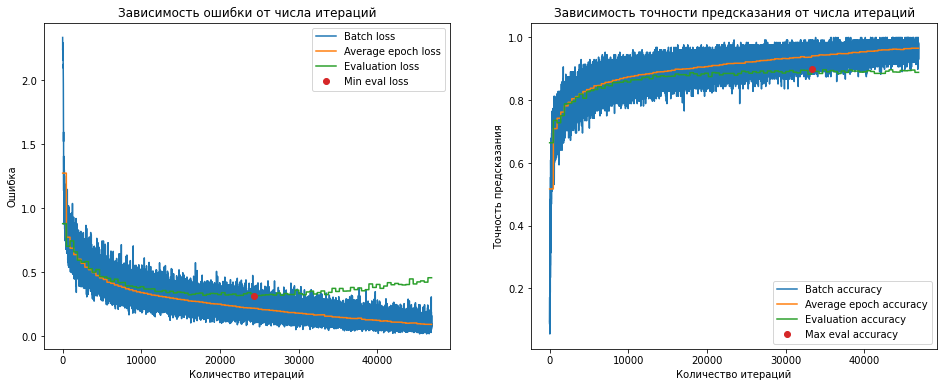

Обучение завершено


In [ ]:
# Сверточная модель со "skip" подключениями + SGD
res_model = FirstModel()
res_model.to(device)

res_history_SGD = train_model(res_model, train_dataloader, optimizer='SGD', epochs=100)

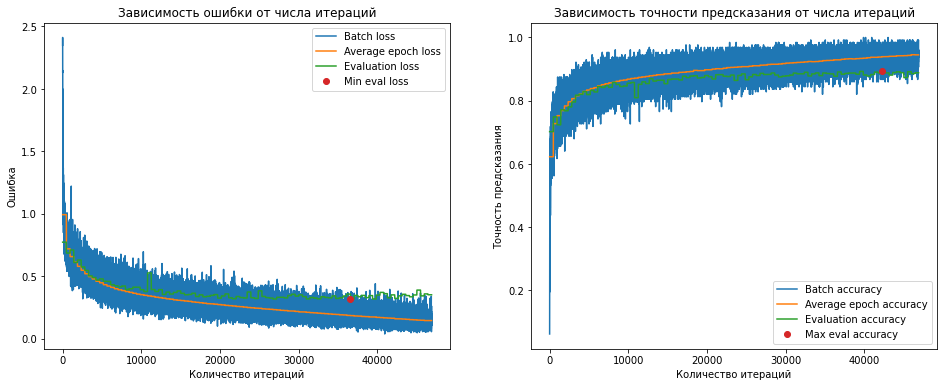

Обучение завершено


In [ ]:
# Сверточная модель со "skip" подключениями + RMSprop
res_model = FirstModel()
res_model.to(device)

res_history_RMSprop = train_model(res_model, train_dataloader, optimizer='RMSprop', epochs=100)

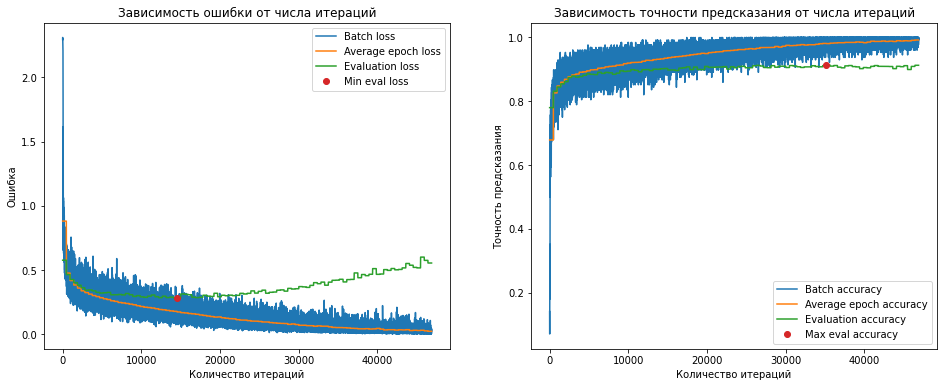

Обучение завершено


In [ ]:
# Сверточная модель + SGD
second_model.to(device)
conv_history_SGD = train_model(second_model, train_dataloader, optimizer='SGD', epochs=100)

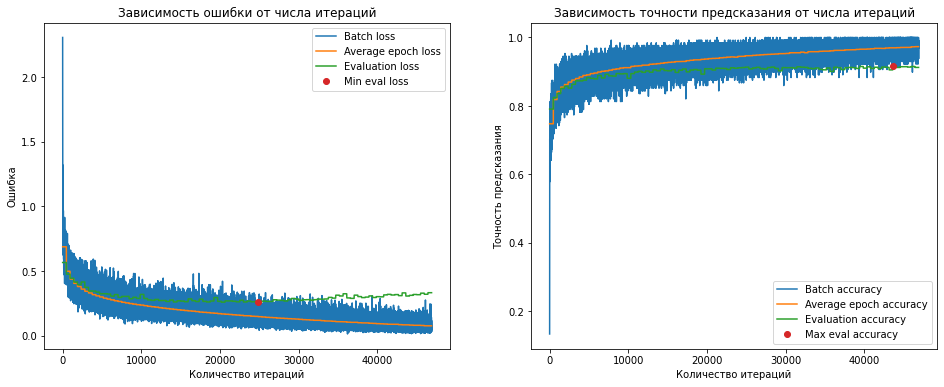

Обучение завершено


In [ ]:
# Сверточная модель + RMSprop
second_model.to(device)
conv_history_RMSprop = train_model(second_model, train_dataloader, optimizer='RMSprop', epochs=100)

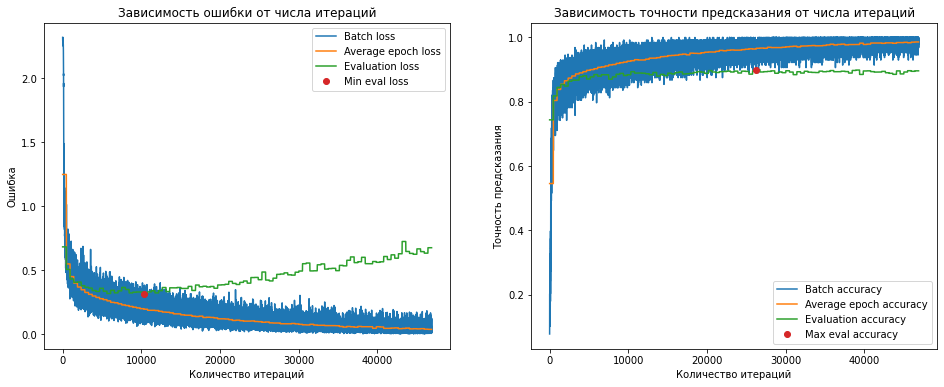

Обучение завершено


In [ ]:
# Полносвязная модель + SGD
lin_model = ThirdModel()
lin_model.to(device)

lin_history_SGD = train_model(lin_model, train_dataloader, optimizer='SGD', epochs=100)

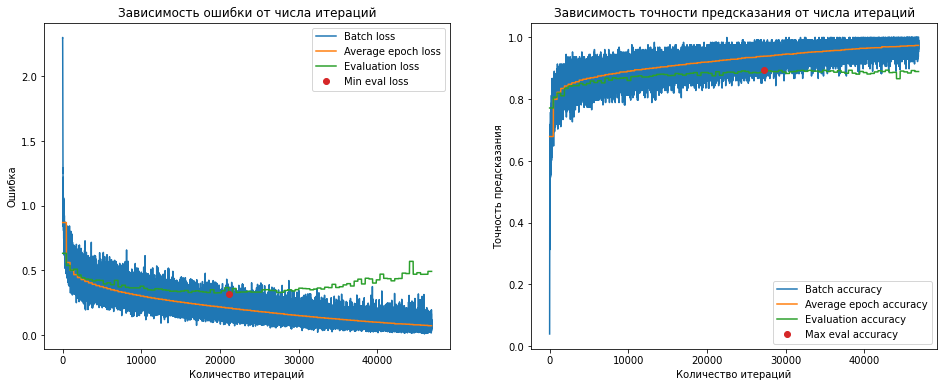

Обучение завершено


In [ ]:
# Полносвязная модель + RMSprop
lin_model = ThirdModel()
lin_model.to(device)

lin_history_RMSprop = train_model(lin_model, train_dataloader, optimizer='RMSprop', epochs=100)

#### Интерпретация результатов

В качестве методов обучения для всех моделей использовался стохастический градиентный спуск с моментом 0.9 и шагом обучения 0.01, а также RMSprop с шагом обучения 0.0001. На графике ниже видно, что все модели имеют схожую сходимость ошибки на батчах, но из-за больших колебаний сложно что-то разбрать.

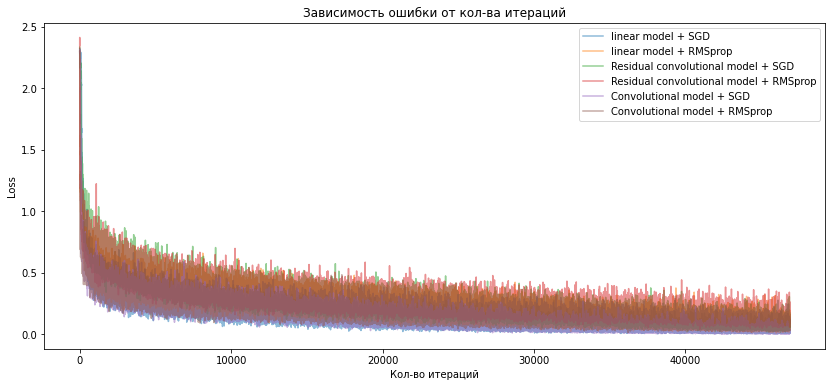

In [ ]:
x_ax = np.arange(len(lin_history_SGD['loss']))
plt.figure(figsize=(14,6))
plt.plot(x_ax, lin_history_SGD['loss'], x_ax, lin_history_RMSprop['loss'],
         x_ax, res_history_SGD['loss'], x_ax, res_history_RMSprop['loss'],
         x_ax, conv_history_SGD['loss'], x_ax, conv_history_RMSprop['loss'],
         alpha=0.5)
plt.title('Зависимость ошибки от кол-ва итераций')
plt.xlabel('Кол-во итераций')
plt.ylabel('Loss')
plt.legend(['linear model + SGD', 'linear model + RMSprop',
            'Residual convolutional model + SGD', 'Residual convolutional model + RMSprop',
            'Convolutional model + SGD', 'Convolutional model + RMSprop'])

plt.show()

На графике средней ошибке за эпоху уже видны различия. Лучше всего сошлась сверточная модель с полносвязными слоями и полносвязная модель со стохастическим градиентным спуском. В то же время глубокая сверточная модель со skip'ами сходится хуже остальных. 

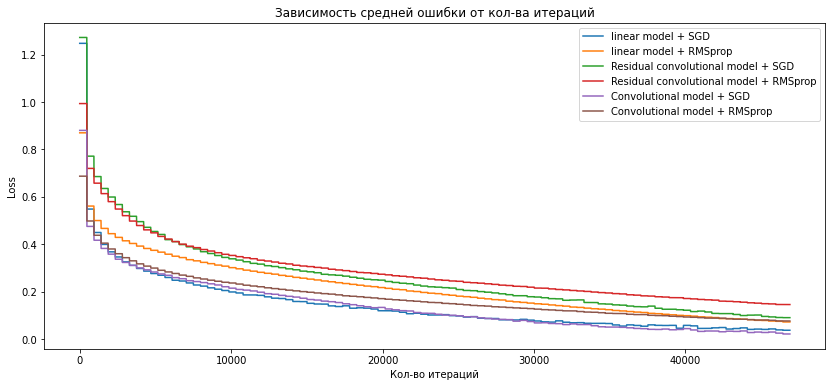

In [ ]:
x_ax = np.arange(len(lin_history_SGD['ep_loss']))
plt.figure(figsize=(14,6))
plt.plot(x_ax, lin_history_SGD['ep_loss'], x_ax, lin_history_RMSprop['ep_loss'],
         x_ax, res_history_SGD['ep_loss'], x_ax, res_history_RMSprop['ep_loss'],
         x_ax, conv_history_SGD['ep_loss'], x_ax, conv_history_RMSprop['ep_loss'],
         alpha=1)
plt.title('Зависимость средней ошибки от кол-ва итераций')
plt.xlabel('Кол-во итераций')
plt.ylabel('Loss')
plt.legend(['linear model + SGD', 'linear model + RMSprop',
            'Residual convolutional model + SGD', 'Residual convolutional model + RMSprop',
            'Convolutional model + SGD', 'Convolutional model + RMSprop'])

plt.show()

На тестовой выборке видно, что примерно после 20 тыс. итераций большинство моделей начинают переобучаться 

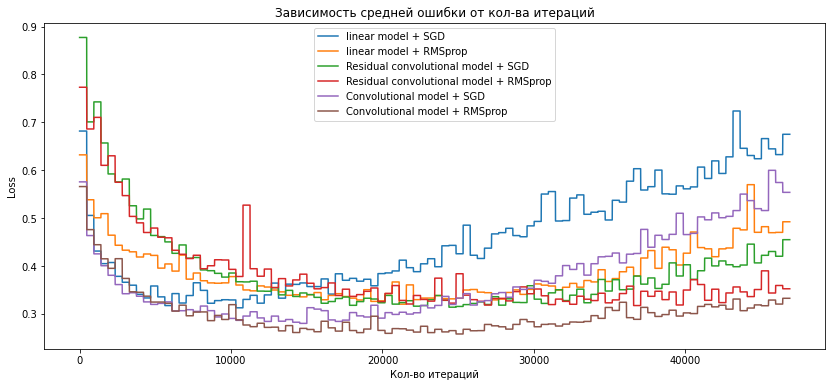

In [ ]:
x_ax = np.arange(len(lin_history_SGD['eval_loss']))
plt.figure(figsize=(14,6))
plt.plot(x_ax, lin_history_SGD['eval_loss'], x_ax, lin_history_RMSprop['eval_loss'],
         x_ax, res_history_SGD['eval_loss'], x_ax, res_history_RMSprop['eval_loss'],
         x_ax, conv_history_SGD['eval_loss'], x_ax, conv_history_RMSprop['eval_loss'],
         alpha=1)
plt.title('Зависимость средней ошибки от кол-ва итераций')
plt.xlabel('Кол-во итераций')
plt.ylabel('Loss')
plt.legend(['linear model + SGD', 'linear model + RMSprop',
            'Residual convolutional model + SGD', 'Residual convolutional model + RMSprop',
            'Convolutional model + SGD', 'Convolutional model + RMSprop'])

plt.show()

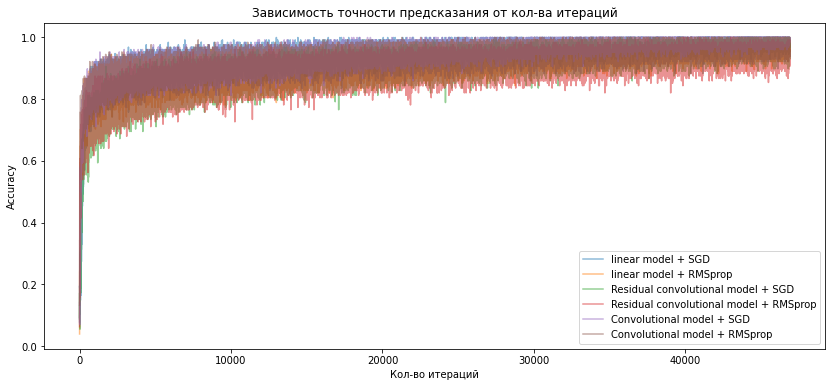

In [ ]:
x_ax = np.arange(len(lin_history_SGD['accuracy']))
plt.figure(figsize=(14,6))
plt.plot(x_ax, lin_history_SGD['accuracy'], x_ax, lin_history_RMSprop['accuracy'],
         x_ax, res_history_SGD['accuracy'], x_ax, res_history_RMSprop['accuracy'],
         x_ax, conv_history_SGD['accuracy'], x_ax, conv_history_RMSprop['accuracy'],
         alpha=0.5)
plt.title('Зависимость точности предсказания от кол-ва итераций')
plt.xlabel('Кол-во итераций')
plt.ylabel('Accuracy')
plt.legend(['linear model + SGD', 'linear model + RMSprop',
            'Residual convolutional model + SGD', 'Residual convolutional model + RMSprop',
            'Convolutional model + SGD', 'Convolutional model + RMSprop'])

plt.show()

По точности на обучающей выборке после 100 эпох обучения лучше всего себя показали сверточная и полносвязная модели. 

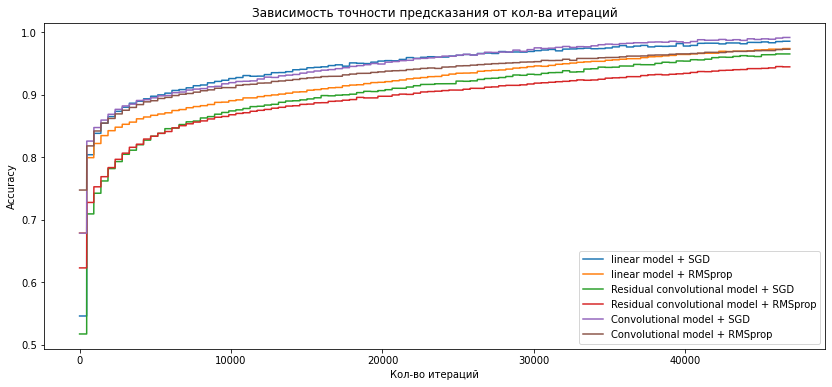

In [ ]:
x_ax = np.arange(len(lin_history_SGD['ep_acc']))
plt.figure(figsize=(14,6))
plt.plot(x_ax, lin_history_SGD['ep_acc'], x_ax, lin_history_RMSprop['ep_acc'],
         x_ax, res_history_SGD['ep_acc'], x_ax, res_history_RMSprop['ep_acc'],
         x_ax, conv_history_SGD['ep_acc'], x_ax, conv_history_RMSprop['ep_acc'],
         alpha=1)
plt.title('Зависимость точности предсказания от кол-ва итераций')
plt.xlabel('Кол-во итераций')
plt.ylabel('Accuracy')
plt.legend(['linear model + SGD', 'linear model + RMSprop',
            'Residual convolutional model + SGD', 'Residual convolutional model + RMSprop',
            'Convolutional model + SGD', 'Convolutional model + RMSprop'])

plt.show()

Тогда как на тестовой выборке сверточная модель отрывается по качеству от остальных, показывая более 90% правильных ответов.

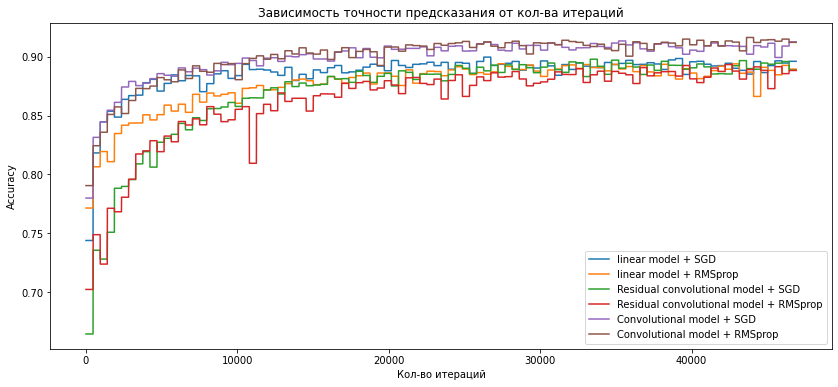

In [ ]:
x_ax = np.arange(len(lin_history_SGD['eval_acc']))
plt.figure(figsize=(14,6))
plt.plot(x_ax, lin_history_SGD['eval_acc'], x_ax, lin_history_RMSprop['eval_acc'],
         x_ax, res_history_SGD['eval_acc'], x_ax, res_history_RMSprop['eval_acc'],
         x_ax, conv_history_SGD['eval_acc'], x_ax, conv_history_RMSprop['eval_acc'],
         alpha=1)
plt.title('Зависимость точности предсказания от кол-ва итераций')
plt.xlabel('Кол-во итераций')
plt.ylabel('Accuracy')
plt.legend(['linear model + SGD', 'linear model + RMSprop',
            'Residual convolutional model + SGD', 'Residual convolutional model + RMSprop',
            'Convolutional model + SGD', 'Convolutional model + RMSprop'])

plt.show()

Интуитивно, самая мощная и глубокая модель должна была показать наилучшее качество. Однако, на мой взгляд, из-за слишком большой глубины ей требуется больше времени обучения на сходимость. Именно поэтому средняя модель, комбинирующая сверточные и полносвязные слои, смогла показать наилучшие показатели за 100 эпох обучения. 

Также видно, что в среднем SGD сходится быстрее, чем RMSprop. Но это связано с, скорее всего с тем, что шаг обучения для SGD был выбран куда больше, чем для RMSprop. К сожалению, RMSprop с lr = 0.01 не показывал сходимости при обучении. Тем не менее, несмотря на такую разницу в величине шага, методы показывают схожие результаты